<a href="https://colab.research.google.com/github/tusharvatsa32/VisTransformers/blob/main/Code/ResNet_101_ImageNet_Weight_Freezing_Final_With_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat May  1 10:06:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q einops

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import os
import random
import torch.nn.functional as F
from torch import einsum
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

plt.ion()   # interactive mode

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(11785)

In [ ]:
device = 'cuda'

In [ ]:
!pip install vision-transformer-pytorch

In [ ]:
!pip install -q pytorch_pretrained_vit

In [ ]:
from vision_transformer_pytorch import VisionTransformer

In [ ]:
!pip install kaggle

In [ ]:
!mkdir .kaggle

In [ ]:
import json
token = {"username":"vivekaswal231","key":"ef136a38387ae54519451b63f002158e"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/
!kaggle config set -n path -v /content

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/
!kaggle config set -n path -v /content

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
!kaggle datasets download -d ifigotin/imagenetmini-1000 -p /content/

100% 3.92G/3.92G [00:42<00:00, 123MB/s]
100% 3.92G/3.92G [00:42<00:00, 98.6MB/s]


In [ ]:
!unzip -q \*.zip

In [ ]:
# Importing Libraries
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import numpy as np                 # for algebric functions
import matplotlib.pyplot as plt    # to plot graph
import PIL


# torch vision package
import torchvision                 # for handling image & has CNN architecture
from torchvision import transforms

In [ ]:
#img_size = ((224, 224)) #For ResNet models
img_size = ((384, 384)) # For ViT predefined weights

transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.RandomCrop(img_size, fill=0),
    transforms.RandomAffine(10, translate=None, scale=(0.8, 1.2), shear=None, fill=0, fillcolor=None, resample=None),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transforms_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
trainset = torchvision.datasets.ImageFolder(root='imagenet-mini/train', transform=transforms_train) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)

testset = torchvision.datasets.ImageFolder(root='imagenet-mini/val', transform=transforms_val)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(trainset), len(trainloader))
print(len(testset), len(testloader))

34745 4344
3923 981


In [ ]:
len(trainset.classes)

1000

In [ ]:
from pytorch_pretrained_vit import ViT
model = ViT('B_32_imagenet1k', pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(trainset.classes))

Loaded pretrained weights.


In [ ]:
numEpochs = 100
in_features = 3 # RGB channels

learningRate = 0.01
weightDecay = 2e-5

num_classes = len(trainset.classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9, nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.4, patience=5, threshold=0.002, verbose=True)

In [ ]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(in_features=768, out_features=1000, bias=True)
)
model = model.to(device)

In [ ]:
# model

In [ ]:
i = 0
for param in model.parameters():
  if i < 187:
    param.requires_grad = False
  else:
    break
  #print(param.requires_grad)
  i+=1
  #print(i)

In [ ]:
train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []

In [ ]:
# Train!
numEpochs = 100
for epoch in range(numEpochs):
    
    # Train
    model.train()
    train_loss = 0.0
    val_loss = 0.0
    train_acc = 0.0
    correct = 0

    for batch_num, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        
        x, y = x.to(device), y.to(device)

        outputs = model(x)

        correct += (torch.argmax(outputs, axis=1) == y).sum().item()

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        del(outputs)

        train_loss += loss.item()

        if batch_num % 100 == 0:
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch, batch_num+1, train_loss/(batch_num+1)))

    train_accuracy = correct / len(trainset)
    train_loss = train_loss/(batch_num+1)

    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)

    # Validate
    model.eval()
    num_correct = 0
    for batch_num1, (x, y) in enumerate(testloader):
        x, y = x.to(device), y.to(device)
        outputs = model(x)

        num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()

        val_loss += loss.item()

    val_accuracy = num_correct / len(testset)
    val_loss = val_loss/(batch_num1+1)

    val_acc_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    print('Epoch: {}\t Training Acc: {:.4f}\t Train Loss: {:.4f}\t Val Acc: {:.4f}\t Val Loss: {:.4f}'.format(epoch, train_accuracy*100, train_loss, val_accuracy * 100, val_loss))
    scheduler.step(val_accuracy)

    #torch.save(network.state_dict(),'/content/drive/MyDrive/DL_CMU/HW2_P2/ResNet_Plateau_d3/Net_'+str(epoch)+'_'+str(val_accuracy)+'_checkpoint.t7')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0	Batch: 1	Avg-Loss: 6.7957
Epoch: 0	Batch: 101	Avg-Loss: 7.0397
Epoch: 0	Batch: 201	Avg-Loss: 7.0088
Epoch: 0	Batch: 301	Avg-Loss: 6.9894
Epoch: 0	Batch: 401	Avg-Loss: 6.9797
Epoch: 0	Batch: 501	Avg-Loss: 6.9702
Epoch: 0	Batch: 601	Avg-Loss: 6.9637
Epoch: 0	Batch: 701	Avg-Loss: 6.9587
Epoch: 0	Batch: 801	Avg-Loss: 6.9551
Epoch: 0	Batch: 901	Avg-Loss: 6.9514
Epoch: 0	Batch: 1001	Avg-Loss: 6.9484
Epoch: 0	Batch: 1101	Avg-Loss: 6.9453
Epoch: 0	Batch: 1201	Avg-Loss: 6.9423
Epoch: 0	Batch: 1301	Avg-Loss: 6.9400
Epoch: 0	Batch: 1401	Avg-Loss: 6.9381
Epoch: 0	Batch: 1501	Avg-Loss: 6.9360
Epoch: 0	Batch: 1601	Avg-Loss: 6.9336
Epoch: 0	Batch: 1701	Avg-Loss: 6.9323
Epoch: 0	Batch: 1801	Avg-Loss: 6.9306
Epoch: 0	Batch: 1901	Avg-Loss: 6.9297
Epoch: 0	Batch: 2001	Avg-Loss: 6.9283
Epoch: 0	Batch: 2101	Avg-Loss: 6.9272
Epoch: 0	Batch: 2201	Avg-Loss: 6.9255
Epoch: 0	Batch: 2301	Avg-Loss: 6.9241
Epoch: 0	Batch: 2401	Avg-Loss: 6.9229
Epoch: 0	Batch: 2501	Avg-Loss: 6.9225
Epoch: 0	Batch: 2601	Avg

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 46	Batch: 2101	Avg-Loss: 0.5146
Epoch: 46	Batch: 2201	Avg-Loss: 0.5120
Epoch: 46	Batch: 2301	Avg-Loss: 0.5113
Epoch: 46	Batch: 2401	Avg-Loss: 0.5101
Epoch: 46	Batch: 2501	Avg-Loss: 0.5122
Epoch: 46	Batch: 2601	Avg-Loss: 0.5100
Epoch: 46	Batch: 2701	Avg-Loss: 0.5101
Epoch: 46	Batch: 2801	Avg-Loss: 0.5111
Epoch: 46	Batch: 2901	Avg-Loss: 0.5101
Epoch: 46	Batch: 3001	Avg-Loss: 0.5086
Epoch: 46	Batch: 3101	Avg-Loss: 0.5082
Epoch: 46	Batch: 3201	Avg-Loss: 0.5069
Epoch: 46	Batch: 3301	Avg-Loss: 0.5068


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 46	Batch: 3401	Avg-Loss: 0.5063
Epoch: 46	Batch: 3501	Avg-Loss: 0.5073
Epoch: 46	Batch: 3601	Avg-Loss: 0.5080
Epoch: 46	Batch: 3701	Avg-Loss: 0.5084
Epoch: 46	Batch: 3801	Avg-Loss: 0.5080
Epoch: 46	Batch: 3901	Avg-Loss: 0.5077
Epoch: 46	Batch: 4001	Avg-Loss: 0.5074
Epoch: 46	Batch: 4101	Avg-Loss: 0.5063
Epoch: 46	Batch: 4201	Avg-Loss: 0.5066
Epoch: 46	Batch: 4301	Avg-Loss: 0.5072
Epoch: 46	 Training Acc: 87.7795	 Train Loss: 0.5069	 Val Acc: 70.3798	 Val Loss: 0.0081
Epoch: 47	Batch: 1	Avg-Loss: 1.0683
Epoch: 47	Batch: 101	Avg-Loss: 0.4674
Epoch: 47	Batch: 201	Avg-Loss: 0.4667
Epoch: 47	Batch: 301	Avg-Loss: 0.4745
Epoch: 47	Batch: 401	Avg-Loss: 0.4718
Epoch: 47	Batch: 501	Avg-Loss: 0.4782
Epoch: 47	Batch: 601	Avg-Loss: 0.4773
Epoch: 47	Batch: 701	Avg-Loss: 0.4830
Epoch: 47	Batch: 801	Avg-Loss: 0.4842
Epoch: 47	Batch: 901	Avg-Loss: 0.4936
Epoch: 47	Batch: 1001	Avg-Loss: 0.4970
Epoch: 47	Batch: 1101	Avg-Loss: 0.4985
Epoch: 47	Batch: 1201	Avg-Loss: 0.4991
Epoch: 47	Batch: 1301	Avg-

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Traceback (most recent call last):
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 47	Batch: 1401	Avg-Loss: 0.4958


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch: 47	Batch: 1501	Avg-Loss: 0.5037
Epoch: 47	Batch: 1601	Avg-Loss: 0.5080
Epoch: 47	Batch: 1701	Avg-Loss: 0.4998
Epoch: 47	Batch: 1801	Avg-Loss: 0.4996


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 47	Batch: 1901	Avg-Loss: 0.4996
Epoch: 47	Batch: 2001	Avg-Loss: 0.4983
Epoch: 47	Batch: 2101	Avg-Loss: 0.4961
Epoch: 47	Batch: 2201	Avg-Loss: 0.4960
Epoch: 47	Batch: 2301	Avg-Loss: 0.4955
Epoch: 47	Batch: 2401	Avg-Loss: 0.4984
Epoch: 47	Batch: 2501	Avg-Loss: 0.4996
Epoch: 47	Batch: 2601	Avg-Loss: 0.5012
Epoch: 47	Batch: 2701	Avg-Loss: 0.5021
Epoch: 47	Batch: 2801	Avg-Loss: 0.5038
Epoch: 47	Batch: 2901	Avg-Loss: 0.5049
Epoch: 47	Batch: 3001	Avg-Loss: 0.5071
Epoch: 47	Batch: 3101	Avg-Loss: 0.5082
Epoch: 47	Batch: 3201	Avg-Loss: 0.5078
Epoch: 47	Batch: 3301	Avg-Loss: 0.5086
Epoch: 47	Batch: 3401	Avg-Loss: 0.5092
Epoch: 47	Batch: 3501	Avg-Loss: 0.5088
Epoch: 47	Batch: 3601	Avg-Loss: 0.5095
Epoch: 47	Batch: 3701	Avg-Loss: 0.5108
Epoch: 47	Batch: 3801	Avg-Loss: 0.5090
Epoch: 47	Batch: 3901	Avg-Loss: 0.5072
Epoch: 47	Batch: 4001	Avg-Loss: 0.5078
Epoch: 47	Batch: 4101	Avg-Loss: 0.5078
Epoch: 47	Batch: 4201	Avg-Loss: 0.5086
Epoch: 47	Batch: 4301	Avg-Loss: 0.5083
Epoch: 47	 Training Acc: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 48	Batch: 301	Avg-Loss: 0.4938


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/

Epoch: 48	Batch: 401	Avg-Loss: 0.4911


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 48	Batch: 501	Avg-Loss: 0.4964


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 48	Batch: 601	Avg-Loss: 0.4998
Epoch: 48	Batch: 701	Avg-Loss: 0.5053
Epoch: 48	Batch: 801	Avg-Loss: 0.5063
Epoch: 48	Batch: 901	Avg-Loss: 0.5129
Epoch: 48	Batch: 1001	Avg-Loss: 0.5128
Epoch: 48	Batch: 1101	Avg-Loss: 0.5071
Epoch: 48	Batch: 1201	Avg-Loss: 0.5003
Epoch: 48	Batch: 1301	Avg-Loss: 0.5027
Epoch: 48	Batch: 1401	Avg-Loss: 0.5036
Epoch: 48	Batch: 1501	Avg-Loss: 0.5068
Epoch: 48	Batch: 1601	Avg-Loss: 0.5060
Epoch: 48	Batch: 1701	Avg-Loss: 0.5056
Epoch: 48	Batch: 1801	Avg-Loss: 0.5053
Epoch: 48	Batch: 1901	Avg-Loss: 0.5053
Epoch: 48	Batch: 2001	Avg-Loss: 0.5093
Epoch: 48	Batch: 2101	Avg-Loss: 0.5078
Epoch: 48	Batch: 2201	Avg-Loss: 0.5097
Epoch: 48	Batch: 2301	Avg-Loss: 0.5118
Epoch: 48	Batch: 2401	Avg-Loss: 0.5092
Epoch: 48	Batch: 2501	Avg-Loss: 0.5082
Epoch: 48	Batch: 2601	Avg-Loss: 0.5090
Epoch: 48	Batch: 2701	Avg-Loss: 0.5086
Epoch: 48	Batch: 2801	Avg-Loss: 0.5072
Epoch: 48	Batch: 2901	Avg-Loss: 0.5090
Epoch: 48	Batch: 3001	Avg-Loss: 0.5079
Epoch: 48	Batch: 3101	Avg-Los

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/lib/pytho

Epoch: 48	 Training Acc: 87.5752	 Train Loss: 0.5152	 Val Acc: 70.4053	 Val Loss: 0.0142


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/

Epoch: 49	Batch: 1	Avg-Loss: 0.3665
Epoch: 49	Batch: 101	Avg-Loss: 0.5441
Epoch: 49	Batch: 201	Avg-Loss: 0.5297
Epoch: 49	Batch: 301	Avg-Loss: 0.5385
Epoch: 49	Batch: 401	Avg-Loss: 0.5169
Epoch: 49	Batch: 501	Avg-Loss: 0.5307
Epoch: 49	Batch: 601	Avg-Loss: 0.5291
Epoch: 49	Batch: 701	Avg-Loss: 0.5170
Epoch: 49	Batch: 801	Avg-Loss: 0.5261
Epoch: 49	Batch: 901	Avg-Loss: 0.5256
Epoch: 49	Batch: 1001	Avg-Loss: 0.5272
Epoch: 49	Batch: 1101	Avg-Loss: 0.5281
Epoch: 49	Batch: 1201	Avg-Loss: 0.5285
Epoch: 49	Batch: 1301	Avg-Loss: 0.5293
Epoch: 49	Batch: 1401	Avg-Loss: 0.5281
Epoch: 49	Batch: 1501	Avg-Loss: 0.5257
Epoch: 49	Batch: 1601	Avg-Loss: 0.5278
Epoch: 49	Batch: 1701	Avg-Loss: 0.5287
Epoch: 49	Batch: 1801	Avg-Loss: 0.5280
Epoch: 49	Batch: 1901	Avg-Loss: 0.5270
Epoch: 49	Batch: 2001	Avg-Loss: 0.5259
Epoch: 49	Batch: 2101	Avg-Loss: 0.5240
Epoch: 49	Batch: 2201	Avg-Loss: 0.5243
Epoch: 49	Batch: 2301	Avg-Loss: 0.5231
Epoch: 49	Batch: 2401	Avg-Loss: 0.5215
Epoch: 49	Batch: 2501	Avg-Loss: 0.520

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 54	Batch: 1601	Avg-Loss: 0.4919


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProce

Epoch: 54	Batch: 1701	Avg-Loss: 0.4926


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
Traceback (most recent call last):
  File "/usr/local/lib/python3

Epoch: 54	Batch: 1801	Avg-Loss: 0.4945
Epoch: 54	Batch: 1901	Avg-Loss: 0.4935
Epoch: 54	Batch: 2001	Avg-Loss: 0.4990
Epoch: 54	Batch: 2101	Avg-Loss: 0.4978
Epoch: 54	Batch: 2201	Avg-Loss: 0.4988
Epoch: 54	Batch: 2301	Avg-Loss: 0.5028
Epoch: 54	Batch: 2401	Avg-Loss: 0.5019
Epoch: 54	Batch: 2501	Avg-Loss: 0.5025
Epoch: 54	Batch: 2601	Avg-Loss: 0.5010
Epoch: 54	Batch: 2701	Avg-Loss: 0.5045
Epoch: 54	Batch: 2801	Avg-Loss: 0.5042
Epoch: 54	Batch: 2901	Avg-Loss: 0.5032
Epoch: 54	Batch: 3001	Avg-Loss: 0.5045
Epoch: 54	Batch: 3101	Avg-Loss: 0.5041
Epoch: 54	Batch: 3201	Avg-Loss: 0.5055
Epoch: 54	Batch: 3301	Avg-Loss: 0.5052
Epoch: 54	Batch: 3401	Avg-Loss: 0.5053
Epoch: 54	Batch: 3501	Avg-Loss: 0.5047
Epoch: 54	Batch: 3601	Avg-Loss: 0.5028
Epoch: 54	Batch: 3701	Avg-Loss: 0.5021
Epoch: 54	Batch: 3801	Avg-Loss: 0.5014
Epoch: 54	Batch: 3901	Avg-Loss: 0.5005
Epoch: 54	Batch: 4001	Avg-Loss: 0.5022
Epoch: 54	Batch: 4101	Avg-Loss: 0.5026
Epoch: 54	Batch: 4201	Avg-Loss: 0.5041
Epoch: 54	Batch: 4301	Avg

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 55	Batch: 1001	Avg-Loss: 0.5162


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 55	Batch: 1101	Avg-Loss: 0.5172
Epoch: 55	Batch: 1201	Avg-Loss: 0.5145
Epoch: 55	Batch: 1301	Avg-Loss: 0.5182
Epoch: 55	Batch: 1401	Avg-Loss: 0.5162
Epoch: 55	Batch: 1501	Avg-Loss: 0.5130
Epoch: 55	Batch: 1601	Avg-Loss: 0.5082
Epoch: 55	Batch: 1701	Avg-Loss: 0.5051
Epoch: 55	Batch: 1801	Avg-Loss: 0.5025
Epoch: 55	Batch: 1901	Avg-Loss: 0.5039
Epoch: 55	Batch: 2001	Avg-Loss: 0.5027
Epoch: 55	Batch: 2101	Avg-Loss: 0.5014
Epoch: 55	Batch: 2201	Avg-Loss: 0.5017
Epoch: 55	Batch: 2301	Avg-Loss: 0.4998
Epoch: 55	Batch: 2401	Avg-Loss: 0.4986
Epoch: 55	Batch: 2501	Avg-Loss: 0.4988
Epoch: 55	Batch: 2601	Avg-Loss: 0.4972
Epoch: 55	Batch: 2701	Avg-Loss: 0.4984
Epoch: 55	Batch: 2801	Avg-Loss: 0.4994
Epoch: 55	Batch: 2901	Avg-Loss: 0.4982
Epoch: 55	Batch: 3001	Avg-Loss: 0.4973
Epoch: 55	Batch: 3101	Avg-Loss: 0.4999
Epoch: 55	Batch: 3201	Avg-Loss: 0.5011
Epoch: 55	Batch: 3301	Avg-Loss: 0.5017
Epoch: 55	Batch: 3401	Avg-Loss: 0.5003
Epoch: 55	Batch: 3501	Avg-Loss: 0.5008
Epoch: 55	Batch: 3601	Avg

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 56	Batch: 401	Avg-Loss: 0.5009


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7fe8ccfb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 56	Batch: 501	Avg-Loss: 0.5022
Epoch: 56	Batch: 601	Avg-Loss: 0.4882
Epoch: 56	Batch: 701	Avg-Loss: 0.4817
Epoch: 56	Batch: 801	Avg-Loss: 0.4813
Epoch: 56	Batch: 901	Avg-Loss: 0.4846
Epoch: 56	Batch: 1001	Avg-Loss: 0.4811
Epoch: 56	Batch: 1101	Avg-Loss: 0.4873
Epoch: 56	Batch: 1201	Avg-Loss: 0.4935
Epoch: 56	Batch: 1301	Avg-Loss: 0.4950
Epoch: 56	Batch: 1401	Avg-Loss: 0.4949
Epoch: 56	Batch: 1501	Avg-Loss: 0.4940
Epoch: 56	Batch: 1601	Avg-Loss: 0.4943
Epoch: 56	Batch: 1701	Avg-Loss: 0.4957
Epoch: 56	Batch: 1801	Avg-Loss: 0.4957
Epoch: 56	Batch: 1901	Avg-Loss: 0.4939
Epoch: 56	Batch: 2001	Avg-Loss: 0.4948
Epoch: 56	Batch: 2101	Avg-Loss: 0.4948
Epoch: 56	Batch: 2201	Avg-Loss: 0.4980
Epoch: 56	Batch: 2301	Avg-Loss: 0.4993
Epoch: 56	Batch: 2401	Avg-Loss: 0.5021
Epoch: 56	Batch: 2501	Avg-Loss: 0.5011
Epoch: 56	Batch: 2601	Avg-Loss: 0.5001
Epoch: 56	Batch: 2701	Avg-Loss: 0.4983
Epoch: 56	Batch: 2801	Avg-Loss: 0.4979
Epoch: 56	Batch: 2901	Avg-Loss: 0.4968
Epoch: 56	Batch: 3001	Avg-Loss

KeyboardInterrupt: ignored

In [ ]:
# 6.1 hours for 56 Epochs

In [ ]:
np.save('B_32_imagenet1k_Val_Acc_Mini_ImageNet1k_56_Epochs', val_acc_list)
np.save('B_32_imagenet1k_Val_Loss_Mini_ImageNet1k_56_Epochs', val_loss_list)
np.save('B_32_imagenet1k_train_Acc_Mini_ImageNet1k_56_Epochs', train_acc_list)
np.save('B_32_imagenet1k_train_Loss_Mini_ImageNet1k_56_Epochs', train_loss_list)

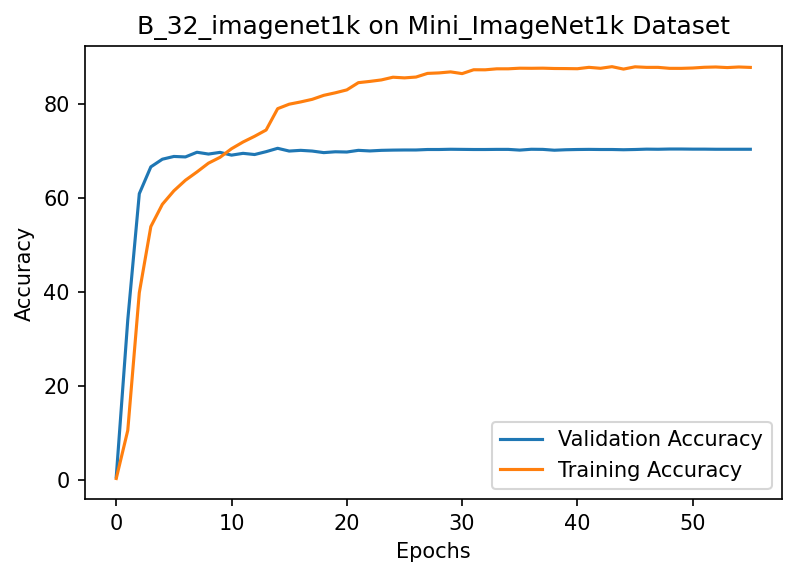

In [ ]:
# 6.1 hours for 56 Epochs
plt.figure(figsize=(6,4), dpi = 150)
plt.plot(np.array(val_acc_list)*100, label = 'Validation Accuracy')
plt.plot(np.array(train_acc_list)*100, label = 'Training Accuracy')
plt.legend()
plt.title('B_32_imagenet1k on Mini_ImageNet1k Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

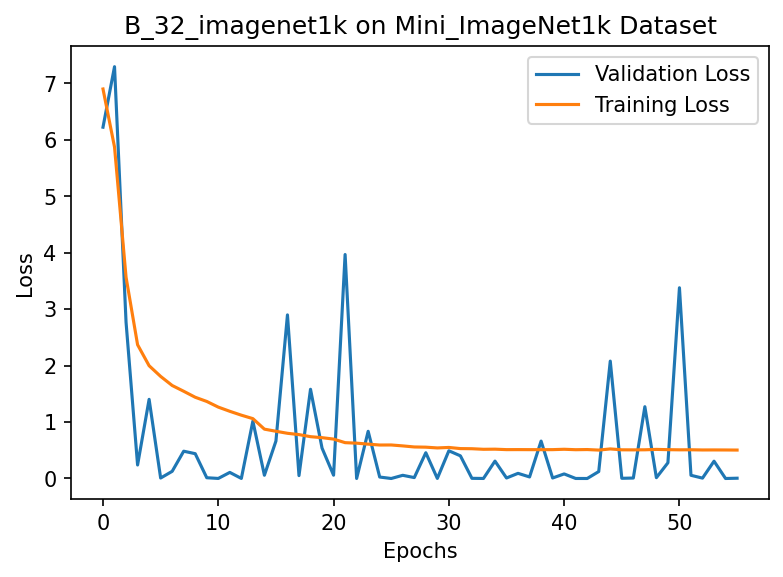

In [ ]:
plt.figure(figsize=(6,4), dpi = 150)
#plt.plot(my_acc, label = 'Validation Accuracy')
plt.plot(np.array(val_loss_list), label = 'Validation Loss')
plt.plot(np.array(train_loss_list), label = 'Training Loss')
plt.legend()
plt.title('B_32_imagenet1k on Mini_ImageNet1k Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()